## imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from evaluate import  get_results, get_cross_validation_scores,plot_parameter_sensitivity
from preprocess import  preprocess_loan_features, prepare_loan_train_test
from sklearn.metrics import classification_report
from scipy.stats import randint
import time
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [9]:
index_name = 'model_name'
column_name = 'randsearch_time'

df_times = pd.DataFrame(
    index = pd.Index([], name=index_name),
    columns = [column_name],
    dtype = np.float64
)

## Base Model

In [19]:
training_data = pd.read_csv("loan-10k.lrn.csv") 
training_data = preprocess_loan_features(training_data)
X_train, X_val, y_train, y_val = prepare_loan_train_test(training_data, scale=True)

              precision    recall  f1-score   support

           A       0.96      0.96      0.96       364
           B       0.94      0.89      0.92       576
           C       0.86      0.95      0.90       598
           D       0.73      0.85      0.79       290
           E       0.61      0.41      0.49       124
           F       0.44      0.11      0.17        37
           G       0.00      0.00      0.00        11

    accuracy                           0.87      2000
   macro avg       0.65      0.60      0.60      2000
weighted avg       0.86      0.87      0.86      2000



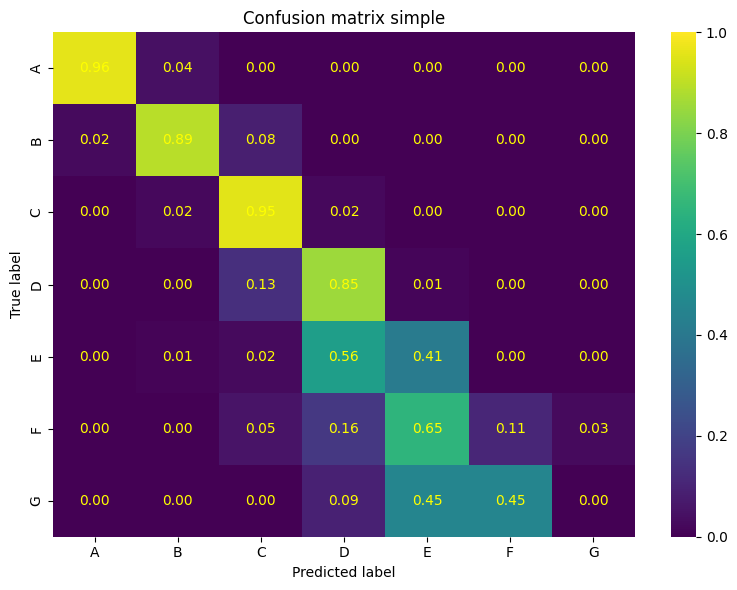

In [4]:
target_names = ["A","B", "C", "D", "E", "F", "G"]
# Train a baseline random forest
rf_base = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    class_weight= 'balanced',
    oob_score=True 
)
rf_base.fit(X_train, y_train)

y_pred_base = rf_base.predict(X_val)

get_results(y_val, y_pred_base, target_names)

In [5]:
get_cross_validation_scores(rf_base, X_train, y_train )

10-Fold CV Scores: [0.85632996 0.86543564 0.84095404 0.83621036 0.84277538 0.85284368
 0.86013396 0.8936667  0.86047544 0.84774219]
Average f1_weighted Score: 0.8557
Standard Deviation: 0.0155


/home/dzsef/.venvs/pandas-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/dzsef/.venvs/pandas-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/dzsef/.venvs/pandas-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

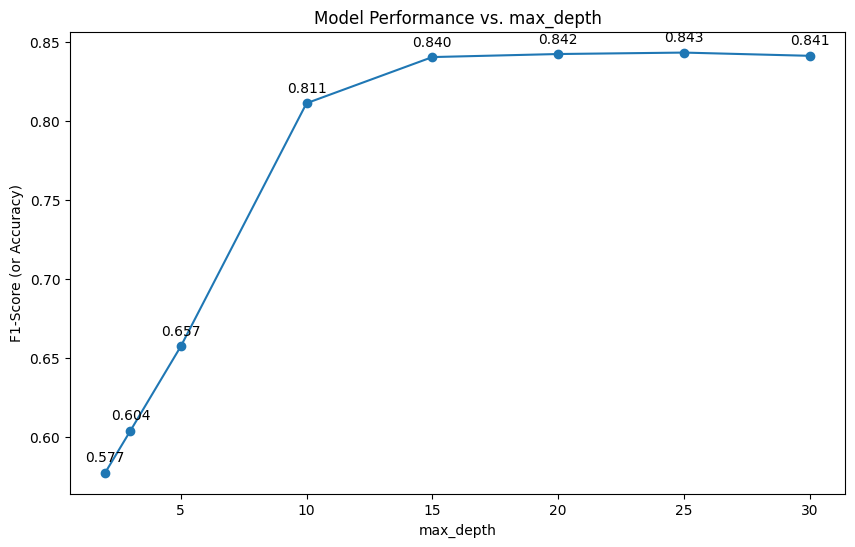

In [20]:
# Checking for the importance of tree depth
# The comparison metric will be F1 score
param_range = [2, 3, 5, 10, 15, 20, 25, 30] 
f1_scores = []

for depth in param_range:
    rf_exp = RandomForestClassifier(
        n_estimators=100, 
        max_depth=depth,  
        random_state=42
    )
    rf_exp.fit(X_train, y_train)
    
    report = classification_report(
        y_val, 
        rf_exp.predict(X_val), 
        output_dict=True
    )
    f1_scores.append(report['weighted avg']['f1-score'])



plot_params = [p if p is not None else max(p for p in param_range if p is not None) + 1 for p in param_range]
plot_parameter_sensitivity(
    param_values=plot_params, 
    scores=f1_scores, 
    param_name="max_depth"
)

The optimal depth for the base model is at 25

In [7]:
model_name = 'rf_scaled'

rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    class_weight= 'balanced',
    oob_score=True 
)
# The parameters to optimize
param_distributions = {
    'n_estimators': randint(200, 1000),
    
    'max_depth': randint(3, 25),
    
    'min_samples_leaf': randint(1, 15),

    'max_features': ['sqrt', 'log2', 0.5]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,  
    cv=5,     
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

df_times.loc[model_name, column_name] = training_time
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best F1-score: {random_search.best_score_:.4f}")

# The final model
final_model = random_search.best_estimator_

Best parameters found: {'max_depth': 19, 'max_features': 0.5, 'min_samples_leaf': 3, 'n_estimators': 488}
Best F1-score: 0.9560


In [9]:
df_times

,randsearch_time
model_name,
rf_scaled,520.471353


              precision    recall  f1-score   support

           A       1.00      0.99      0.99       364
           B       0.98      0.98      0.98       576
           C       0.97      0.97      0.97       598
           D       0.95      0.96      0.95       290
           E       0.88      0.96      0.92       124
           F       0.72      0.76      0.74        37
           G       0.25      0.09      0.13        11

    accuracy                           0.96      2000
   macro avg       0.82      0.81      0.81      2000
weighted avg       0.96      0.96      0.96      2000



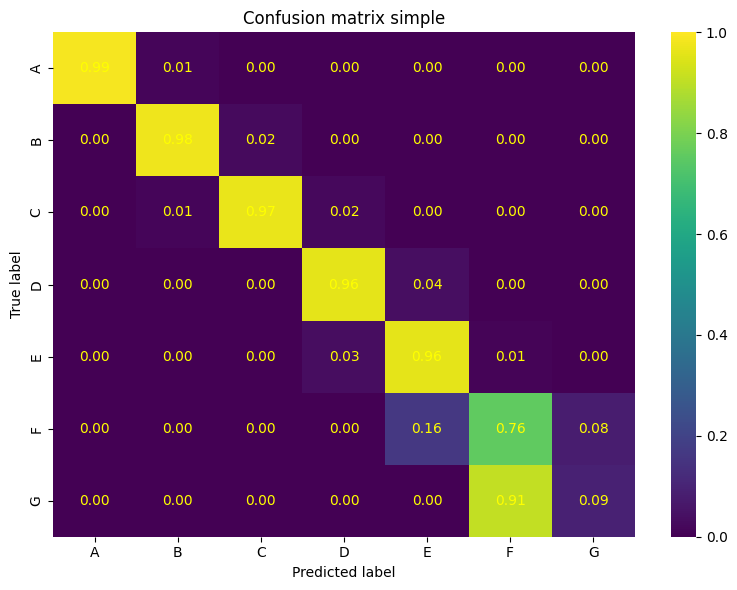

In [10]:
y_pred = final_model.predict(X_val)
get_results(y_val, y_pred, target_names)

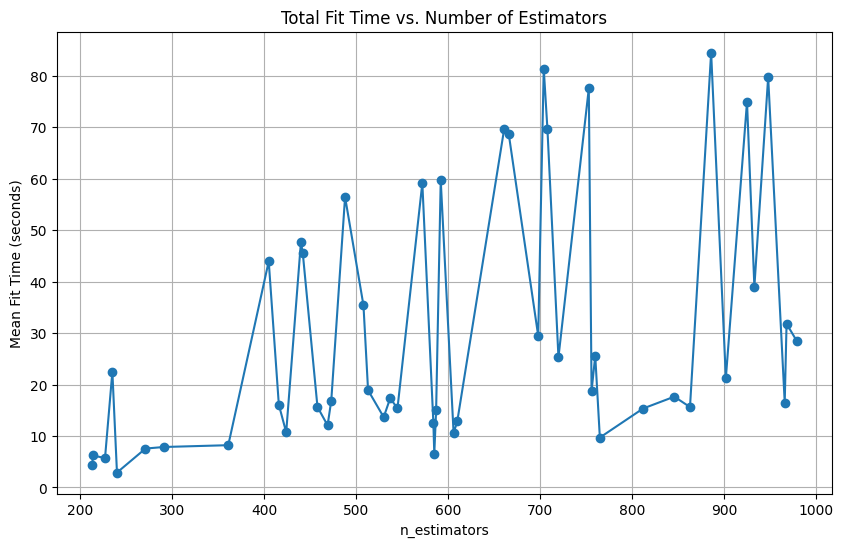

In [11]:
results = random_search.cv_results_
df_results = pd.DataFrame({
    'n_estimators' : results['param_n_estimators'],
    'mean_fit_time': results['mean_fit_time']
})

df_results = df_results.sort_values(by = 'n_estimators')

plt.figure(figsize = (10,6))
plt.plot(df_results['n_estimators'], df_results['mean_fit_time'], marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Mean Fit Time (seconds)')
plt.title('Total Fit Time vs. Number of Estimators')
plt.grid(True)
plt.show()

## Unscaled

              precision    recall  f1-score   support

           A       0.96      0.96      0.96       364
           B       0.94      0.89      0.92       576
           C       0.86      0.95      0.91       598
           D       0.74      0.86      0.79       290
           E       0.60      0.41      0.49       124
           F       0.44      0.11      0.17        37
           G       0.00      0.00      0.00        11

    accuracy                           0.87      2000
   macro avg       0.65      0.60      0.61      2000
weighted avg       0.86      0.87      0.86      2000



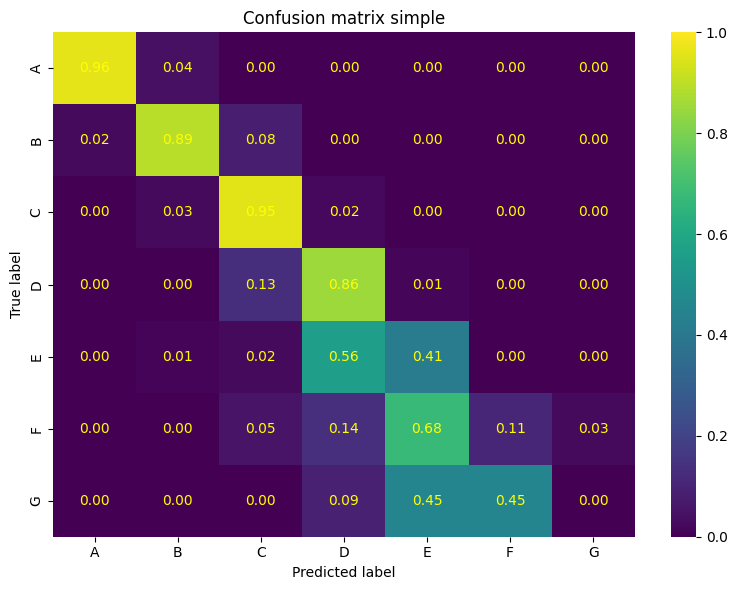

In [6]:
training_data = pd.read_csv("loan-10k.lrn.csv") 
training_data = preprocess_loan_features(training_data)
X_train, X_val, y_train, y_val = prepare_loan_train_test(training_data, scale=False)
target_names = ["A","B", "C", "D", "E", "F", "G"]
# Train a baseline random forest
rf_base = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    class_weight= 'balanced',
    oob_score=True 
)
rf_base.fit(X_train, y_train)

y_pred_base = rf_base.predict(X_val)

get_results(y_val, y_pred_base, target_names)

In [7]:
#validation_scores = cross_val_score(rf_base, X_train, y_train, cv=10, scoring = 'f1_weighted')
get_cross_validation_scores(rf_base, X_train, y_train )

10-Fold CV Scores: [0.85880956 0.86426039 0.84186114 0.83913866 0.84028631 0.85444624
 0.86353343 0.88934335 0.86213375 0.84774219]
Average f1_weighted Score: 0.8562
Standard Deviation: 0.0144


In [ ]:
model_name = 'rf_unscaled'

rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    class_weight= 'balanced',
    oob_score=True 
)
# The parameters to optimize
param_distributions = {
    'n_estimators': randint(200, 1000),
    
    'max_depth': randint(3, 25),
    
    'min_samples_leaf': randint(1, 15),

    'max_features': ['sqrt', 'log2', 0.5]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,  
    cv=5,     
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time



In [10]:
df_times.loc[model_name, column_name] = training_time
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best F1-score: {random_search.best_score_:.4f}")

# The final model
final_model = random_search.best_estimator_

Best parameters found: {'max_depth': 19, 'max_features': 0.5, 'min_samples_leaf': 3, 'n_estimators': 488}
Best F1-score: 0.9560


In [11]:
get_cross_validation_scores(rf, X_train, y_train )

10-Fold CV Scores: [0.85880956 0.86426039 0.84186114 0.83913866 0.84028631 0.85444624
 0.86353343 0.88934335 0.86213375 0.84774219]
Average f1_weighted Score: 0.8562
Standard Deviation: 0.0144


With Transform


In [3]:
training_data = pd.read_csv("loan-10k.lrn.csv") 
target_col = "grade"
id_col = "ID" 
feature_cols = [c for c in training_data.columns if c not in [target_col, id_col]]
X_all = training_data[feature_cols]
y_all = training_data[target_col].astype(str)
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)
numeric_cols = X_all.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in feature_cols if c not in numeric_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numeric_cols),
        ("cat", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("encode", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
        ]), categorical_cols),
    ],
    remainder="drop",
)

rf_model = RandomForestClassifier(
    n_estimators=800,
    max_depth=None,
    min_samples_leaf=5,
    max_features="sqrt",
    class_weight="balanced",   
    n_jobs=-1,
    random_state=42,
)

rf_pipeline = Pipeline([
    ("prep", preprocess),
    ("model", rf_model),
])

param_space = {
    "model__n_estimators": [400, 800, 1200],
    "model__max_depth":  [None, 10, 20, 30],
    "model__min_samples_leaf": [1, 2, 5, 10],
    "model__max_features": ["sqrt", "log2", 0.5],
    "model__class_weight": [None, "balanced", "balanced_subsample"],
}

search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_space,
    n_iter=15,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X_train, y_train)

best_pipeline = search.best_estimator_
y_val_pred = best_pipeline.predict(X_val).astype(str)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [4]:
print(f"Best parameters found: {search.best_params_}")
print(f"Best F1-score: {search.best_score_:.4f}")

Best parameters found: {'model__n_estimators': 800, 'model__min_samples_leaf': 2, 'model__max_features': 0.5, 'model__max_depth': 30, 'model__class_weight': 'balanced_subsample'}
Best F1-score: 0.9607


              precision    recall  f1-score   support

           A       1.00      0.99      0.99       364
           B       0.98      0.98      0.98       576
           C       0.98      0.98      0.98       598
           D       0.96      0.97      0.96       290
           E       0.88      0.95      0.91       124
           F       0.71      0.73      0.72        37
           G       0.40      0.18      0.25        11

    accuracy                           0.97      2000
   macro avg       0.84      0.82      0.83      2000
weighted avg       0.97      0.97      0.97      2000



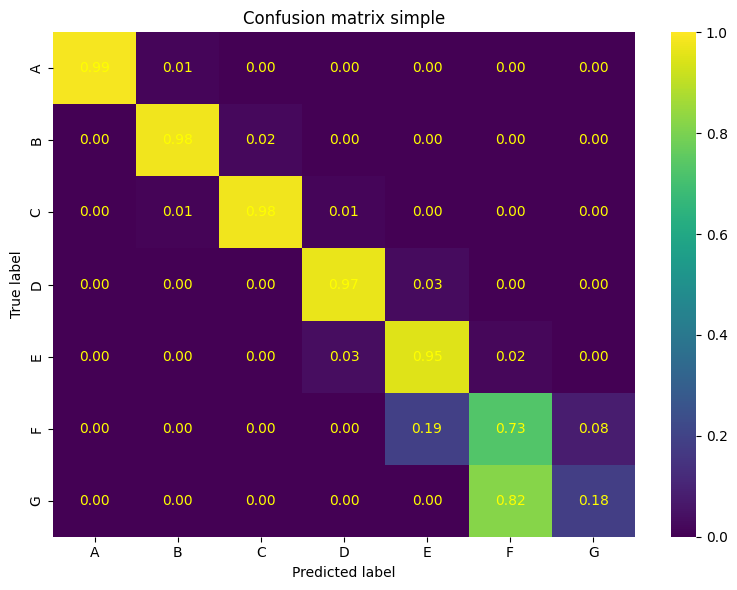

In [13]:
get_results(y_val, y_val_pred, target_names)

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    best_pipeline, X_train, y_train,
    cv=cv, scoring="accuracy", n_jobs=-1
)

print(f"CV accuracy : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy : 0.9631 ± 0.0052
